In [1]:
from google.colab import drive

#mount drive
drive.mount('/content/drive')
#locate the file in google drive
path = '/drive/My Drive/dataset_equip_inf'

Mounted at /content/drive


In [2]:
#show numbers image every class
!ls /content/drive/MyDrive/dataset_equip_inf/gabinetes/ | wc -l
!ls /content/drive/MyDrive/dataset_equip_inf/impressoras/ | wc -l
!ls /content/drive/MyDrive/dataset_equip_inf/laptops/ | wc -l
!ls /content/drive/MyDrive/dataset_equip_inf/monitors/ | wc -l
!ls /content/drive/MyDrive/dataset_equip_inf/mouses/ | wc -l
!ls /content/drive/MyDrive/dataset_equip_inf/teclados/ | wc -l

560
576
598
921
1110
771


In [3]:
!mkdir dataset
!mkdir dataset/gabinetes
!mkdir dataset/impressoras
!mkdir dataset/laptops
!mkdir dataset/monitors
!mkdir dataset/mouses
!mkdir dataset/teclados

In [5]:
#Copiar imagenes que subimos a carpetas del dataset
#Limitar para que todos tengan la misma cantidad de imagenes
#maximo 560 (el num. menor de imagenes que subi)
import os
import shutil
#gabinetes
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/gabinetes'
carpeta_destino = '/content/dataset/gabinetes'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)


In [6]:
#impressoras
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/impressoras'
carpeta_destino = '/content/dataset/impressoras'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [7]:
#laptops
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/laptops'
carpeta_destino = '/content/dataset/laptops'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [8]:
#monitors
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/monitors'
carpeta_destino = '/content/dataset/monitors'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [9]:
#mouses
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/mouses'
carpeta_destino = '/content/dataset/mouses'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [10]:
#teclados
carpeta_fuente = '/content/drive/MyDrive/dataset_equip_inf/teclados'
carpeta_destino = '/content/dataset/teclados'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 560:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

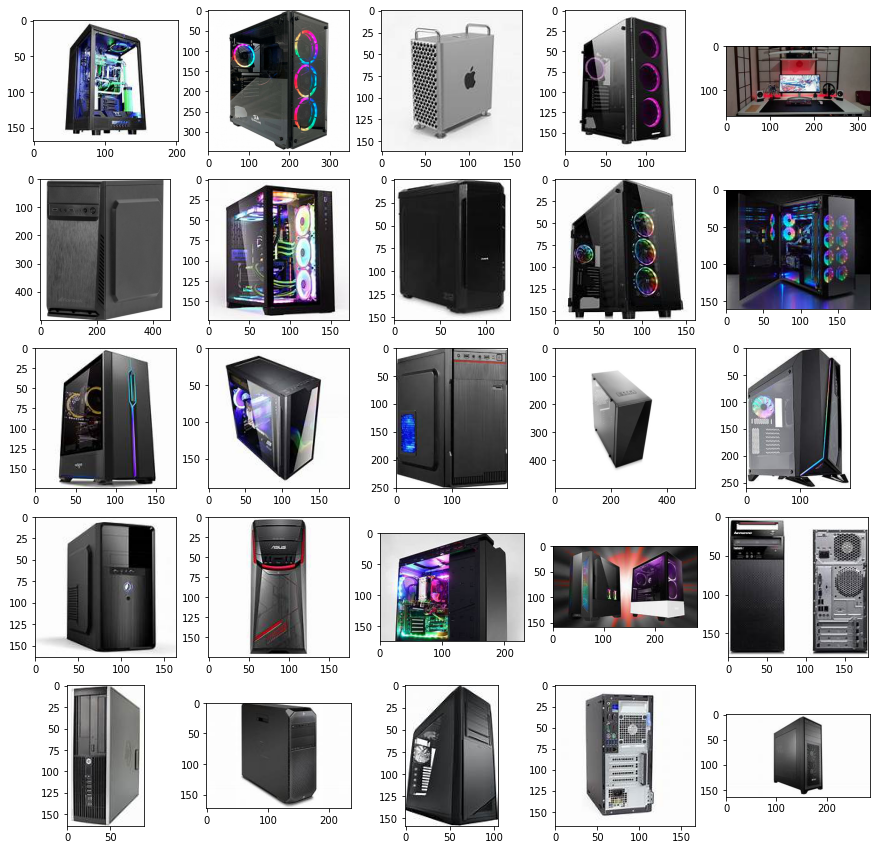

In [11]:
#show some image from folder
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))
gabinetes = '/content/dataset/gabinetes/'
img_gabinetes = os.listdir(gabinetes)

for i, nameimg in enumerate(img_gabinetes[:25]):
  plt.subplot(5,5,i+1)
  img = mpimg.imread(gabinetes + '/' + nameimg)
  plt.imshow(img)


Found 2682 images belonging to 6 classes.
Found 669 images belonging to 6 classes.


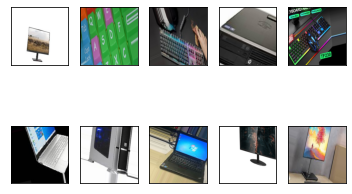

In [14]:
#data augmentations with ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#create data generator
datagen = ImageDataGenerator(
    rescale = 1. /255, #val between 0 and 1, not between 0 and 255
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split = 0.2 #20% for data test
)

#generators for training and validation data
datagen_training = datagen.flow_from_directory('/content/dataset/', 
                                               target_size = (224,224), batch_size = 32,
                                               shuffle = True, subset = 'training'
                                               )
datagen_validation = datagen.flow_from_directory('/content/dataset/', 
                                               target_size = (224,224), batch_size = 32,
                                               shuffle = True, subset = 'validation'
                                               )
#print 10 image from training subset
for image, label in datagen_training:
  for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[i])
  break
plt.show()

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
#we use data transfer strategy of an existing network, in this case mobilenet
url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

#download the model and indicate the way you expect our images
mobilenetv2 = hub.KerasLayer(url,input_shape=(224,224,3))

#we freeze the parameters of the model so as not to lose them
mobilenetv2.trainable = False

#our model
modelo = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(6, activation='softmax')
])

modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
modelo.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [17]:
#training model with generators of training and validations
EPOCHS = 50
historial = modelo.fit(
    datagen_training, epochs = EPOCHS, batch_size = 32,
    validation_data = datagen_validation
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


84/84 [==============================] - 73s 723ms/step - loss: 0.6589 - accuracy: 0.7916 - val_loss: 0.3539 - val_accuracy: 0.8864
Epoch 2/50
84/84 [==============================] - 59s 699ms/step - loss: 0.2957 - accuracy: 0.9057 - val_loss: 0.3336 - val_accuracy: 0.8984
Epoch 3/50
84/84 [==============================] - 59s 705ms/step - loss: 0.2579 - accuracy: 0.9142 - val_loss: 0.3480 - val_accuracy: 0.8999
Epoch 4/50
84/84 [==============================] - 58s 696ms/step - loss: 0.2497 - accuracy: 0.9165 - val_loss: 0.3262 - val_accuracy: 0.8894
Epoch 5/50
84/84 [==============================] - 59s 710ms/step - loss: 0.2361 - accuracy: 0.9187 - val_loss: 0.3223 - val_accuracy: 0.8879
Epoch 6/50
84/84 [==============================] - 58s 691ms/step - loss: 0.2159 - accuracy: 0.9243 - val_loss: 0.2399 - val_accuracy: 0.9163
Epoch 7/50
84/84 [==============================] - 59s 702ms/step - loss: 0.1991 - accuracy: 0.9407 - val_loss: 0.2937 - val_accuracy: 0.8924
Epoch 8/50

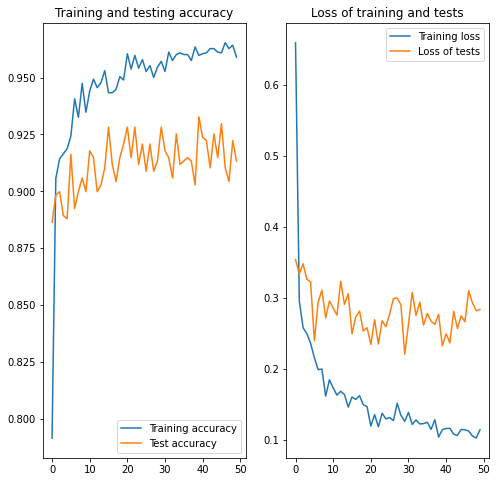

In [18]:
#precision graphics
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Training accuracy')
plt.plot(rango_epocas, val_acc, label='Test accuracy')
plt.legend(loc='lower right')
plt.title('Training and testing accuracy')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Training loss')
plt.plot(rango_epocas, val_loss, label='Loss of tests')
plt.legend(loc='upper right')
plt.title('Loss of training and tests')
plt.show()

In [19]:
from PIL import Image
import requests
from io import BytesIO
import cv2

def categorizar(url):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img = np.array(img).astype(float)/255

  img = cv2.resize(img, (224,224))
  prediction = modelo.predict(img.reshape(-1,224,224,3))
  return np.argmax(prediction[0], axis = -1)


In [20]:
#0 gabinete, 1 impresora, 2 laptop, 3 monitor, 4 mouse, 5 teclado
url_gab = 'https://i.ebayimg.com/images/g/tNwAAOSwX3hiHYu9/s-l500.png'
url_imp = 'https://i.ebayimg.com/images/g/-74AAOSwJPVdWRU2/s-l500.jpg'
url_lap = 'https://i.ebayimg.com/images/g/hkYAAOSwgJ5hYb68/s-l500.jpg'
url_mon = 'https://i.ebayimg.com/images/g/UpEAAOSwS9JfDufF/s-l500.jpg'
url_mou = 'https://i.ebayimg.com/images/g/KJoAAOSw0aVfAYih/s-l500.jpg'
url_tec = 'https://i.ebayimg.com/images/g/rAQAAOSwNaJiN-LV/s-l500.jpg'

prediction_gab = categorizar(url_gab)
print(prediction_gab)
prediction_imp = categorizar(url_imp)
print(prediction_imp)
prediction_lap = categorizar(url_lap)
print(prediction_lap)
prediction_mon = categorizar(url_mon)
print(prediction_mon)
prediction_mou = categorizar(url_mou)
print(prediction_mou)
prediction_tec = categorizar(url_tec)
print(prediction_tec)

url_mon2 = 'https://i.ebayimg.com/images/g/JcMAAOSwrjxiPliz/s-l500.jpg'
prediction_mon2 = categorizar(url_mon2)
print(prediction_mon2)

0
1
2
3
4
5
3


In [21]:
#save model h5 format
modelo.save('rnc_equip_inf.h5')

In [22]:
#transform model to tensorflow.js
!pip install tensorflowjs

     |████████████████████████████████| 77 kB 3.1 MB/s 
     |████████████████████████████████| 462 kB 33.0 MB/s 


In [23]:
#create folder to convert
!mkdir convertjs_folder

In [24]:
#to do the convertion
!tensorflowjs_converter --input_format keras rnc_equip_inf.h5 convertjs_folder

In [25]:
#review content to folder and download to pc
!ls convertjs_folder

group1-shard1of3.bin  group1-shard2of3.bin  group1-shard3of3.bin  model.json
